In [6]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
pip install torchviz


Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


import torch
import gc
# from GPUtil import showUtilization as gpu_usage


## shared code

In [10]:
# essential functions 
def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [11]:
# extract the main info from the label into three columns 

def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")


In [12]:
# write back the class number to the annotiation file
def get_image_class(item, classes_map):
    for k,v in classes_map.items():
        if v == item:
            return k
    return None
    
def write_class_colum(df, with_class_caption_file, classes_map):
    for _,line in df.iterrows():
        image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color),classes_map)

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")


In [13]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [14]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(type(classes))
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 5).permute(1,2,0))
        break


In [15]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [16]:
### Training Code
def train_classification_model(model, epochs, train_data_loader, val_data_loader, device):
    from tqdm import tqdm

    for epoch in range(epochs):
        start = time.time()

        #Epoch Loss & Accuracy
        train_epoch_loss = []
        train_epoch_accuracy = []
        _iter = 1

        #Val Loss & Accuracy
        val_epoch_loss = []
        val_epoch_accuracy = []

        # Training
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,_ in tepoch: 
                images = images.to(device)
                labels = labels.to(device)

                #Reset Grads
                optimizer.zero_grad()

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss & Backward, Update Weights (Step)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()

                #Append loss & acc
                loss_value = loss.item()
                train_epoch_loss.append(loss_value)
                train_epoch_accuracy.append(acc)

                tepoch.set_postfix({'train_epoch_loss': loss_value})
    #             tepoch.set_postfix({'train_epoch_accuracy',acc})

                if _iter % 500 == 0:
                    print("> Iteration {} < ".format(_iter))
                    print("Iter Loss = {}".format(round(loss_value, 4)))
                    print("Iter Accuracy = {} % \n".format(acc))

    #             _iter += 1

        # tryinf to free the memory
        gc.collect()
        torch.cuda.empty_cache()
        gpu_usage()                             

        #Validation
        with tqdm(val_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,_ in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss
                loss = criterion(preds, labels)

                #Append loss & acc
                loss_value = loss.item()
                val_epoch_loss.append(loss_value)
                val_epoch_accuracy.append(acc)
                tepoch.set_postfix({'val_epoch_loss': loss_value})
    #             tepoch.set_postfix({'val_epoch_accuracy',acc})


        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_accuracy = np.mean(train_epoch_accuracy)

        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracy)

        end = time.time()

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #Print Epoch Statistics
        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    return model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy




In [17]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



# Train on dataset with single object

## Data preprocessing 

In [18]:

MISSING_TOKEN = 'None'

In [22]:
data_location =  '../baseline-gen-data/small/'
# data_location =  '/home/space/datasets/COA/generated-data-api-single/'
caption_file = data_location + 'captions-psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'




In [23]:
creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [24]:
write_break_down_columns(caption_file, new_caption_file)

In [25]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,image_0.png,lion,None,A,284055.562500,238163.890625
1,image_1.png,lion,None,A,347488.750000,323990.218750
2,image_2.png,lion,rampant,A,284055.562500,238163.890625
3,image_3.png,lion,rampant,A,347488.750000,323990.218750
4,image_4.png,lion,passt,A,289033.093750,245082.781250
...,...,...,...,...,...,...
146,image_146.png,lion,passt guard,O,244794.031250,183035.484375
147,image_147.png,lion,passt guard,O,275677.281250,222645.234375
148,image_148.png,lion's,head,O,244669.765625,182592.937500
149,image_149.png,lion's,head,O,277891.625000,225355.921875


In [26]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod          color
lion    None         A        6
        passt guard  A        6
lion's  head         O        6
                     B        6
                     A        6
lion    rampant      O        6
                     B        6
                     A        6
        None         B        6
        passt guard  B        6
                     O        6
        passt        O        6
        None         O        6
        passt        B        6
                     A        6
        None         S        5
        passt        V        4
        rampant      S        4
lion's  head         S        4
lion    None         G        4
lion's  head         G        4
lion    rampant      V        4
                     G        4
        None         V        4
        passt        S        4
        passt guard  V        4
                     S        4
        passt        G        4
        passt guard  G        4
lion's  head         V        4
dtype: int64

In [27]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'None', 'A'),
 ('lion', 'passt guard', 'A'),
 ("lion's", 'head', 'O'),
 ("lion's", 'head', 'B'),
 ("lion's", 'head', 'A'),
 ('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'B'),
 ('lion', 'rampant', 'A'),
 ('lion', 'None', 'B'),
 ('lion', 'passt guard', 'B'),
 ('lion', 'passt guard', 'O'),
 ('lion', 'passt', 'O'),
 ('lion', 'None', 'O'),
 ('lion', 'passt', 'B'),
 ('lion', 'passt', 'A'),
 ('lion', 'None', 'S'),
 ('lion', 'passt', 'V'),
 ('lion', 'rampant', 'S'),
 ("lion's", 'head', 'S'),
 ('lion', 'None', 'G'),
 ("lion's", 'head', 'G'),
 ('lion', 'rampant', 'V'),
 ('lion', 'rampant', 'G'),
 ('lion', 'None', 'V'),
 ('lion', 'passt', 'S'),
 ('lion', 'passt guard', 'V'),
 ('lion', 'passt guard', 'S'),
 ('lion', 'passt', 'G'),
 ('lion', 'passt guard', 'G'),
 ("lion's", 'head', 'V')]

In [28]:
len(classes)

30

In [29]:
type(classes[0])

tuple

In [30]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'None', 'A'),
 1: ('lion', 'passt guard', 'A'),
 2: ("lion's", 'head', 'O'),
 3: ("lion's", 'head', 'B'),
 4: ("lion's", 'head', 'A'),
 5: ('lion', 'rampant', 'O'),
 6: ('lion', 'rampant', 'B'),
 7: ('lion', 'rampant', 'A'),
 8: ('lion', 'None', 'B'),
 9: ('lion', 'passt guard', 'B'),
 10: ('lion', 'passt guard', 'O'),
 11: ('lion', 'passt', 'O'),
 12: ('lion', 'None', 'O'),
 13: ('lion', 'passt', 'B'),
 14: ('lion', 'passt', 'A'),
 15: ('lion', 'None', 'S'),
 16: ('lion', 'passt', 'V'),
 17: ('lion', 'rampant', 'S'),
 18: ("lion's", 'head', 'S'),
 19: ('lion', 'None', 'G'),
 20: ("lion's", 'head', 'G'),
 21: ('lion', 'rampant', 'V'),
 22: ('lion', 'rampant', 'G'),
 23: ('lion', 'None', 'V'),
 24: ('lion', 'passt', 'S'),
 25: ('lion', 'passt guard', 'V'),
 26: ('lion', 'passt guard', 'S'),
 27: ('lion', 'passt', 'G'),
 28: ('lion', 'passt guard', 'G'),
 29: ("lion's", 'head', 'V')}

In [31]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [32]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [33]:
write_class_colum(df, new_with_class_caption_file, CLASSES_MAP)
    

In [34]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,image_0.png,lion,None,A,284055.562500,238163.890625,0
1,image_1.png,lion,None,A,347488.750000,323990.218750,0
2,image_2.png,lion,rampant,A,284055.562500,238163.890625,7
3,image_3.png,lion,rampant,A,347488.750000,323990.218750,7
4,image_4.png,lion,passt,A,289033.093750,245082.781250,14
...,...,...,...,...,...,...,...
146,image_146.png,lion,passt guard,O,244794.031250,183035.484375,10
147,image_147.png,lion,passt guard,O,275677.281250,222645.234375,10
148,image_148.png,lion's,head,O,244669.765625,182592.937500,2
149,image_149.png,lion's,head,O,277891.625000,225355.921875,2


In [35]:
train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 90 train images
There are 30 val images
There are 31 test images


,image,charge,mod,color,psum,psum_sq,class
0,image_9.png,lion's,head,A,350546.187500,328025.812500,4
1,image_67.png,lion,passt guard,A,236740.328125,174789.718750,1
2,image_97.png,lion,passt guard,S,167096.406250,94594.171875,26
3,image_71.png,lion,None,B,194746.531250,120326.750000,8
4,image_47.png,lion,passt guard,G,300963.406250,266169.656250,28
5,image_133.png,lion,rampant,B,254627.468750,196696.843750,6
6,image_57.png,lion,passt guard,V,298968.062500,263112.750000,25
7,image_104.png,lion,passt,G,191927.140625,118235.531250,27
8,image_77.png,lion,passt guard,B,195224.046875,120707.968750,9
9,image_112.png,lion,rampant,V,187443.406250,113108.265625,21


# Dataset and Dataloader  

In [36]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [42]:
BATCH_SIZE = 56
# NUM_WORKER = 2 #### this needs multi-core
NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [43]:
images_location = data_location + '/res_images'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [44]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(56, 0)), tensor([], size=(56, 0)))

In [45]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [46]:
std = get_std(train_dataset, train_data_loader, mean, 500 , 500)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


tensor(17538242.5547, dtype=torch.float64)
tensor(22455138.7344, dtype=torch.float64)
tensor(10068120.2498, dtype=torch.float64)
67500000


In [47]:
mean, std

(tensor(0.3327, dtype=torch.float64), tensor(0.3862, dtype=torch.float64))

# Dataset and Dataloader  

In [48]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [49]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=../baseline-gen-data/small//res_images, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.33266872199074077, std=0.3862089292520918)
 ), device=cpu, df=            image  charge          mod color           psum        psum_sq  \
 0    image_79.png  lion's         head     B  197396.968750  123000.906250   
 1    image_68.png  lion's         head     A  259501.296875  205110.421875   
 2    image_25.png    lion        passt     O  336349.906250  308768.218750   
 3    image_41.png    lion         None     G  303233.656250  268962.531250   
 4    image_51.png    lion         None     V  301378.187500  266111.281250   
 ..            ...     ...          ...   ...            ...            ...   
 85  image_147.png    lion  passt guard     O  275677.281250  222645.234375   
 86   image_96.png    lion  passt guard     S  1670

In [50]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


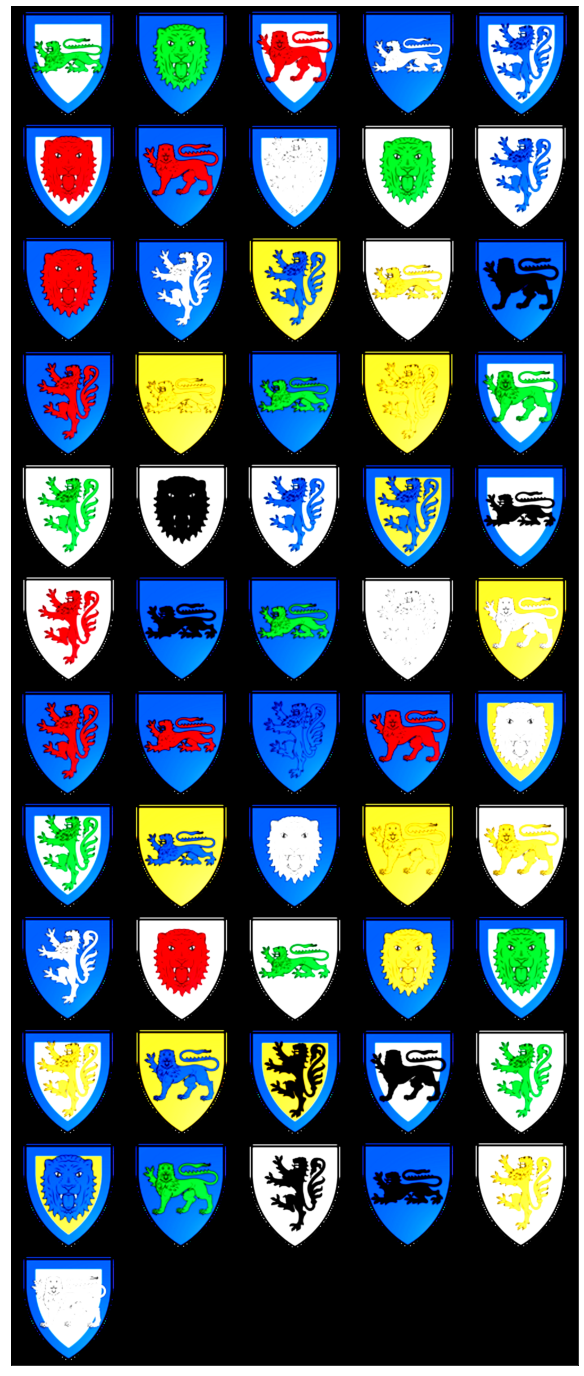

In [51]:


visualize_one_batch(train_data_loader)

Caption: image_39.png lion's head S
(100, 100, 4)


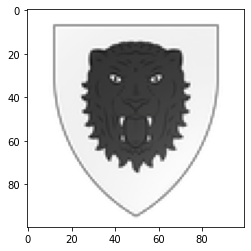

In [52]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


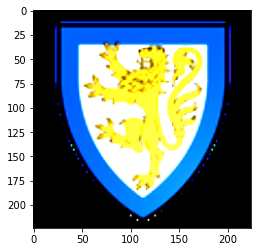

In [53]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


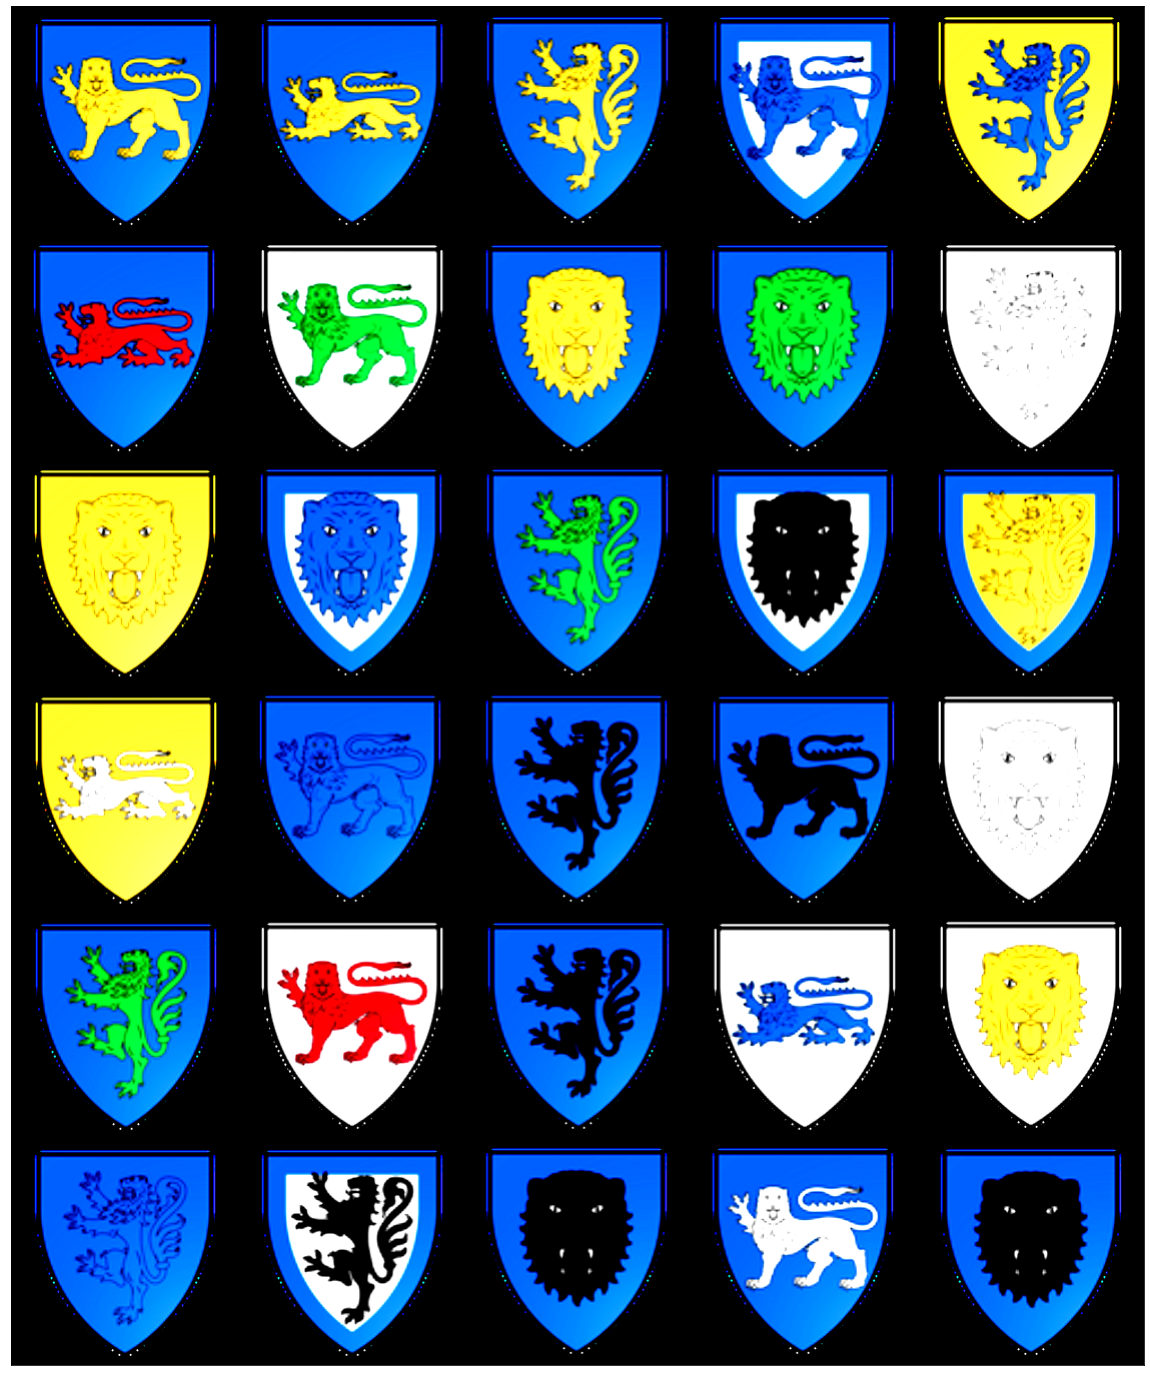

In [54]:
visualize_one_batch(val_data_loader)

# Model Definition

In [64]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


In [65]:

from torchviz import make_dot, make_dot_from_trace

make_dot(model, params=dict(model.named_parameters()))


AttributeError: 'Sequential' object has no attribute 'size'

# Model Training, Validation and Testing

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 25
CUDA_LAUNCH_BLOCKING=1

In [40]:
CUDA_LAUNCH_BLOCKING=1

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model, epochs, train_data_loader, val_data_loader, device)


Epoch 0: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.08batch/s, val_epoch_loss=3.94]


** Epoch 0 ** - Epoch Time 6
Train Loss = 4.565
Train Accuracy = 5.3571375 % 

Val Loss = 3.6557
Val Accuracy = 15.922600000000001 % 



Epoch 1: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.08batch/s, val_epoch_loss=2.19]


** Epoch 1 ** - Epoch Time 6
Train Loss = 2.6319
Train Accuracy = 26.8303625 % 

Val Loss = 2.3209
Val Accuracy = 30.952366666666666 % 



Epoch 2: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.07batch/s, val_epoch_loss=1.96]


** Epoch 2 ** - Epoch Time 6
Train Loss = 1.6042
Train Accuracy = 49.151775 % 

Val Loss = 1.9575
Val Accuracy = 46.57736666666667 % 



Epoch 3: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.08batch/s, val_epoch_loss=1.58]


** Epoch 3 ** - Epoch Time 6
Train Loss = 1.033
Train Accuracy = 65.803575 % 

Val Loss = 1.4915
Val Accuracy = 54.01783333333333 % 



Epoch 4: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.01batch/s, val_epoch_loss=1.14]


** Epoch 4 ** - Epoch Time 6
Train Loss = 0.7065
Train Accuracy = 78.03572500000001 % 

Val Loss = 1.0814
Val Accuracy = 66.51786666666666 % 



Epoch 5: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.08batch/s, val_epoch_loss=0.817]


** Epoch 5 ** - Epoch Time 6
Train Loss = 0.4795
Train Accuracy = 83.9732125 % 

Val Loss = 1.0009
Val Accuracy = 63.9881 % 



Epoch 6: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.06batch/s, val_epoch_loss=0.628]


** Epoch 6 ** - Epoch Time 6
Train Loss = 0.4832
Train Accuracy = 83.258925 % 

Val Loss = 0.7703
Val Accuracy = 74.10713333333332 % 



Epoch 7: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.02batch/s, val_epoch_loss=1.02]


** Epoch 7 ** - Epoch Time 6
Train Loss = 0.3084
Train Accuracy = 89.5535625 % 

Val Loss = 0.8115
Val Accuracy = 71.7262 % 



Epoch 8: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.17batch/s, val_epoch_loss=1.16]


** Epoch 8 ** - Epoch Time 6
Train Loss = 0.2705
Train Accuracy = 90.66965 % 

Val Loss = 0.8233
Val Accuracy = 72.1726 % 



Epoch 9: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.04batch/s, val_epoch_loss=0.869]


** Epoch 9 ** - Epoch Time 6
Train Loss = 0.289
Train Accuracy = 90.44645 % 

Val Loss = 0.8345
Val Accuracy = 75.2976 % 



Epoch 10: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.04batch/s, val_epoch_loss=0.712]


** Epoch 10 ** - Epoch Time 6
Train Loss = 0.2425
Train Accuracy = 92.36608749999999 % 

Val Loss = 0.6908
Val Accuracy = 77.9762 % 



Epoch 11: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.06batch/s, val_epoch_loss=0.461]


** Epoch 11 ** - Epoch Time 6
Train Loss = 0.1804
Train Accuracy = 92.9464375 % 

Val Loss = 0.8047
Val Accuracy = 78.125 % 



Epoch 12: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.04batch/s, val_epoch_loss=0.747]


** Epoch 12 ** - Epoch Time 6
Train Loss = 0.18
Train Accuracy = 92.7232125 % 

Val Loss = 0.8648
Val Accuracy = 78.125 % 



Epoch 13: 100%|███████████████████████████| 3/3 [00:01<00:00,  1.97batch/s, val_epoch_loss=0.536]


** Epoch 13 ** - Epoch Time 6
Train Loss = 0.1629
Train Accuracy = 92.8571375 % 

Val Loss = 0.6927
Val Accuracy = 80.05953333333333 % 



Epoch 14: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.02batch/s, val_epoch_loss=0.791]


** Epoch 14 ** - Epoch Time 6
Train Loss = 0.1483
Train Accuracy = 93.5267875 % 

Val Loss = 0.8192
Val Accuracy = 75.0 % 



Epoch 15: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.11batch/s, val_epoch_loss=1.05]


** Epoch 15 ** - Epoch Time 6
Train Loss = 0.1477
Train Accuracy = 92.41069999999999 % 

Val Loss = 0.8879
Val Accuracy = 79.61309999999999 % 



Epoch 16: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.03batch/s, val_epoch_loss=0.442]


** Epoch 16 ** - Epoch Time 6
Train Loss = 0.1398
Train Accuracy = 92.3660375 % 

Val Loss = 0.7236
Val Accuracy = 77.38093333333335 % 



Epoch 17: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.00batch/s, val_epoch_loss=0.912]


** Epoch 17 ** - Epoch Time 6
Train Loss = 0.1333
Train Accuracy = 93.4375125 % 

Val Loss = 0.8306
Val Accuracy = 77.38096666666667 % 



Epoch 18: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.04batch/s, val_epoch_loss=1.65]


** Epoch 18 ** - Epoch Time 6
Train Loss = 0.1408
Train Accuracy = 92.4107125 % 

Val Loss = 1.1734
Val Accuracy = 76.6369 % 



Epoch 19: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.01batch/s, val_epoch_loss=0.907]


** Epoch 19 ** - Epoch Time 6
Train Loss = 0.131
Train Accuracy = 93.3035625 % 

Val Loss = 0.8807
Val Accuracy = 78.125 % 



Epoch 20: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.03batch/s, val_epoch_loss=0.594]


** Epoch 20 ** - Epoch Time 6
Train Loss = 0.1109
Train Accuracy = 94.46427500000001 % 

Val Loss = 1.0652
Val Accuracy = 75.89283333333333 % 



Epoch 21: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.04batch/s, val_epoch_loss=1.05]


** Epoch 21 ** - Epoch Time 6
Train Loss = 0.1394
Train Accuracy = 93.39285000000001 % 

Val Loss = 1.1593
Val Accuracy = 77.23213333333332 % 



Epoch 22: 100%|███████████████████████████| 3/3 [00:01<00:00,  2.08batch/s, val_epoch_loss=0.623]


** Epoch 22 ** - Epoch Time 6
Train Loss = 0.1508
Train Accuracy = 92.0535625 % 

Val Loss = 0.8037
Val Accuracy = 82.14286666666668 % 



Epoch 23: 100%|████████████████████████████| 3/3 [00:01<00:00,  2.29batch/s, val_epoch_loss=1.14]


** Epoch 23 ** - Epoch Time 6
Train Loss = 0.1551
Train Accuracy = 92.85714999999999 % 

Val Loss = 1.2044
Val Accuracy = 75.59523333333334 % 



Epoch 24: 100%|████████████████████████████| 3/3 [00:01<00:00,  1.98batch/s, val_epoch_loss=1.05]

** Epoch 24 ** - Epoch Time 6
Train Loss = 0.1431
Train Accuracy = 92.6339375 % 

Val Loss = 1.0144
Val Accuracy = 77.38093333333333 % 



## Save model to disk

In [41]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [42]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [ ]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


model_file_path =  data_location + '/classification-model-12-04-2022-14:34:36.pth'
saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

In [44]:
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Test Loss = 0.9708
Test Accuracy = 78.27383333333334 % 



## Test pretrained model on real data - single


In [48]:
# real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
# real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


real_caption_file = real_data_location + 'test_real_captions_psumsq_single_cleaned.txt'
new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single_cleaned.txt'


In [50]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,-1_A G lion rampant.jpg,lion,rampant,G,1.884397e+06,1.445564e+06
1,-1_B G lion passt.jpg,lion,passt,G,8.101359e+04,5.683241e+04
2,-1_B O cross.jpg,cross,None,O,1.532679e+06,9.868818e+05
3,-1_G O cross moline.jpg,cross,moline,O,1.928653e+06,1.383184e+06
4,-1_G O lion rampant.jpg,lion,rampant,O,1.657027e+06,1.124069e+06
...,...,...,...,...,...,...
188,9189_A G cross.jpg,cross,None,G,7.879020e+05,6.028561e+05
189,9298_G O lion rampant.jpg,lion,rampant,O,7.961530e+05,5.912544e+05
190,9771_B O eagle.jpg,eagle,None,O,3.113132e+05,1.837900e+05
191,9929_A S eagle.jpg,eagle,None,S,6.978210e+05,5.172552e+05


In [51]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file, CLASSES_MAP)


In [52]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,-1_A G lion rampant.jpg,lion,rampant,G,1.884397e+06,1.445564e+06,20
1,-1_B G lion passt.jpg,lion,passt,G,8.101359e+04,5.683241e+04,8
2,-1_B O cross.jpg,cross,None,O,1.532679e+06,9.868818e+05,34
3,-1_G O cross moline.jpg,cross,moline,O,1.928653e+06,1.383184e+06,40
4,-1_G O lion rampant.jpg,lion,rampant,O,1.657027e+06,1.124069e+06,21
...,...,...,...,...,...,...,...
188,9189_A G cross.jpg,cross,None,G,7.879020e+05,6.028561e+05,33
189,9298_G O lion rampant.jpg,lion,rampant,O,7.961530e+05,5.912544e+05,21
190,9771_B O eagle.jpg,eagle,None,O,3.113132e+05,1.837900e+05,52
191,9929_A S eagle.jpg,eagle,None,S,6.978210e+05,5.172552e+05,53


In [53]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [54]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [55]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


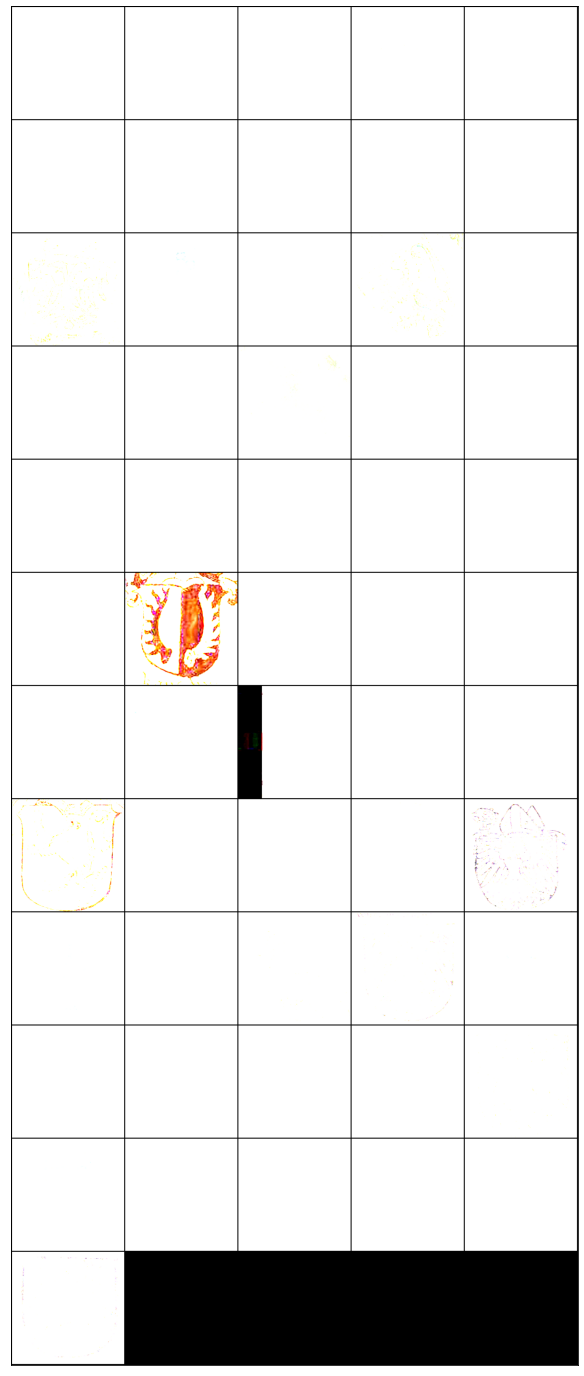

In [57]:

visualize_one_batch(real_test_data_loader)


In [58]:
test_classification_model(model, real_test_data_loader)


Test Loss = 3.7955
Test Accuracy = 19.839275 % 



## Test pretrained model on real data - single & plural


In [59]:
# real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


real_caption_file = real_data_location + 'test_real_captions_psumsq_single-and-plural_cleaned.txt'
new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single-and-plural_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single-and-plural_cleaned.txt'


In [60]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05


In [61]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file, CLASSES_MAP)


In [62]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05,None
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05,None
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05,None
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05,None
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05,None
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05,None
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06,None
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05,None
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05,None
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05,None


In [ ]:
# it's clear from the output above that plural gets None as a class. We didn't train our baseline model on any plural

In [63]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [64]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [65]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tuple'>


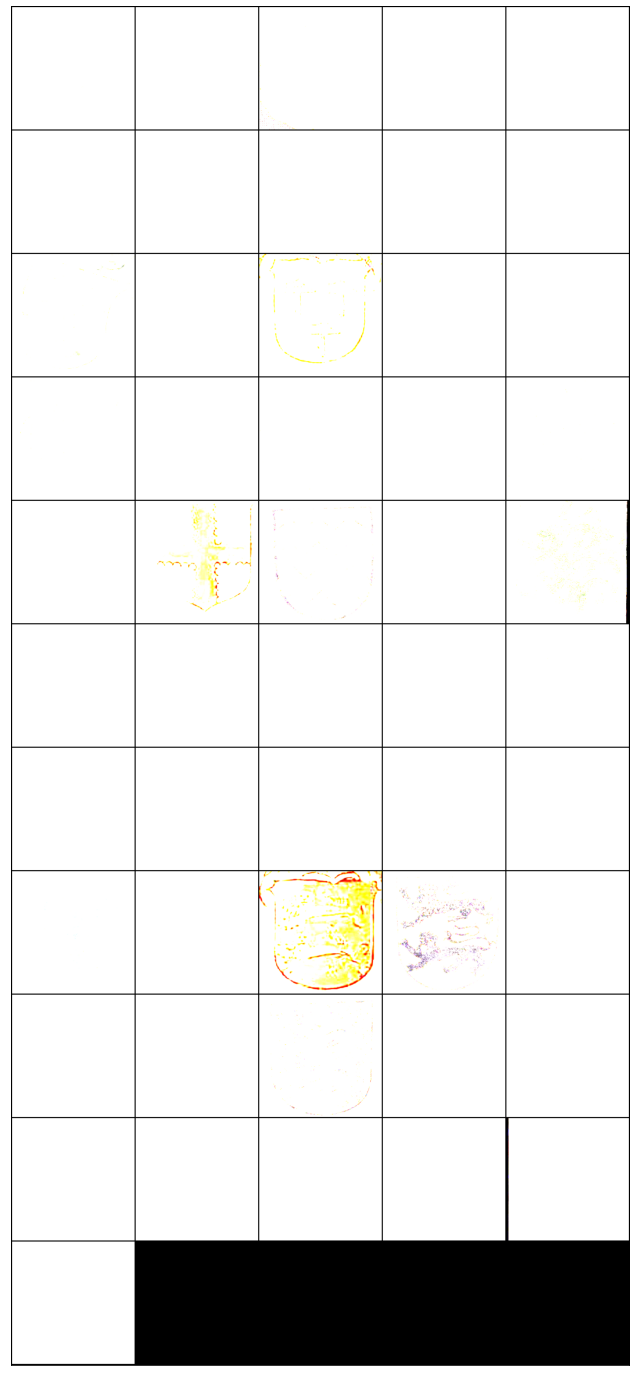

In [67]:

visualize_one_batch(real_test_data_loader)


In [69]:
test_classification_model(model, real_test_data_loader)


<class 'tuple'>


AttributeError: 'tuple' object has no attribute 'to'

# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------

# Train on dataset with single and plural object

## Data preprocessing 

In [72]:

MISSING_TOKEN = 'None'

In [73]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/space/datasets/COA/generated-data-api-single-and-plural/'
caption_file = data_location + 'captions-psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'




In [74]:
creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [75]:
write_break_down_columns(caption_file, new_caption_file)

In [76]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,image_0.png,lion,None,A,11761.910156,9478.757812
1,image_1.png,lion,None,A,14548.799805,13190.972656
2,image_2.png,lion,rampant,A,11761.910156,9478.757812
3,image_3.png,lion,rampant,A,14548.799805,13190.972656
4,image_4.png,lion,passt,A,11961.236328,9800.056641
...,...,...,...,...,...,...
5035,image_5035.png,eagles,doubleheaded,V,7250.152832,4044.833984
5036,image_5036.png,eagles,None,V,7701.486816,4471.107422
5037,image_5037.png,eagles,None,V,7264.317383,4060.355957
5038,image_5038.png,eagles,doubleheaded,V,7687.772949,4455.843750


In [77]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod           color
lions   rampant       V        120
        None          V        120
                      O        120
                      B        120
                      A        120
                              ... 
eagle   doubleheaded  G         12
                      B         12
                      A         12
        None          V         12
lion    passt         A         12
Length: 96, dtype: int64

In [78]:
classes = list(column_values.to_dict().keys())
classes

[('lions', 'rampant', 'V'),
 ('lions', 'None', 'V'),
 ('lions', 'None', 'O'),
 ('lions', 'None', 'B'),
 ('lions', 'None', 'A'),
 ('eagles', 'None', 'A'),
 ('eagles', 'None', 'B'),
 ('eagles', 'None', 'G'),
 ('eagles', 'None', 'O'),
 ('eagles', 'None', 'S'),
 ('eagles', 'None', 'V'),
 ('eagles', 'doubleheaded', 'A'),
 ('eagles', 'doubleheaded', 'B'),
 ('eagles', 'doubleheaded', 'G'),
 ('eagles', 'doubleheaded', 'O'),
 ('eagles', 'doubleheaded', 'S'),
 ('eagles', 'doubleheaded', 'V'),
 ('lions', 'None', 'S'),
 ('lions', 'None', 'G'),
 ('lions', 'passt', 'A'),
 ('lions', 'passt', 'B'),
 ('lions', 'rampant', 'S'),
 ('lions', 'rampant', 'O'),
 ('lions', 'rampant', 'G'),
 ('lions', 'rampant', 'B'),
 ('lions', 'rampant', 'A'),
 ('lions', 'passt guard', 'V'),
 ('lions', 'passt guard', 'S'),
 ('lions', 'passt guard', 'O'),
 ('lions', 'passt guard', 'G'),
 ('lions', 'passt guard', 'B'),
 ('lions', 'passt guard', 'A'),
 ('lions', 'passt', 'V'),
 ('lions', 'passt', 'S'),
 ('lions', 'passt', 'O'),


In [79]:
len(classes)

96

In [80]:
type(classes[0])

tuple

In [82]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP_PLURAL = {}
for i in range(len(classes)):
    CLASSES_MAP_PLURAL[i] = classes[i]
    
CLASSES_MAP_PLURAL


{0: ('lions', 'rampant', 'V'),
 1: ('lions', 'None', 'V'),
 2: ('lions', 'None', 'O'),
 3: ('lions', 'None', 'B'),
 4: ('lions', 'None', 'A'),
 5: ('eagles', 'None', 'A'),
 6: ('eagles', 'None', 'B'),
 7: ('eagles', 'None', 'G'),
 8: ('eagles', 'None', 'O'),
 9: ('eagles', 'None', 'S'),
 10: ('eagles', 'None', 'V'),
 11: ('eagles', 'doubleheaded', 'A'),
 12: ('eagles', 'doubleheaded', 'B'),
 13: ('eagles', 'doubleheaded', 'G'),
 14: ('eagles', 'doubleheaded', 'O'),
 15: ('eagles', 'doubleheaded', 'S'),
 16: ('eagles', 'doubleheaded', 'V'),
 17: ('lions', 'None', 'S'),
 18: ('lions', 'None', 'G'),
 19: ('lions', 'passt', 'A'),
 20: ('lions', 'passt', 'B'),
 21: ('lions', 'rampant', 'S'),
 22: ('lions', 'rampant', 'O'),
 23: ('lions', 'rampant', 'G'),
 24: ('lions', 'rampant', 'B'),
 25: ('lions', 'rampant', 'A'),
 26: ('lions', 'passt guard', 'V'),
 27: ('lions', 'passt guard', 'S'),
 28: ('lions', 'passt guard', 'O'),
 29: ('lions', 'passt guard', 'G'),
 30: ('lions', 'passt guard', 'B

In [83]:
classes_to_int = CLASSES_MAP_PLURAL.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [84]:
new_with_class_caption_file = data_location + '/new-labels-plural-class-psumsq.txt'


In [85]:
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [86]:
write_class_colum(df, new_with_class_caption_file,CLASSES_MAP_PLURAL)
    

In [87]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,image_0.png,lion,None,A,11761.910156,9478.757812,87
1,image_1.png,lion,None,A,14548.799805,13190.972656,87
2,image_2.png,lion,rampant,A,11761.910156,9478.757812,36
3,image_3.png,lion,rampant,A,14548.799805,13190.972656,36
4,image_4.png,lion,passt,A,11961.236328,9800.056641,95
...,...,...,...,...,...,...,...
5035,image_5035.png,eagles,doubleheaded,V,7250.152832,4044.833984,16
5036,image_5036.png,eagles,None,V,7701.486816,4471.107422,10
5037,image_5037.png,eagles,None,V,7264.317383,4060.355957,10
5038,image_5038.png,eagles,doubleheaded,V,7687.772949,4455.843750,16


In [89]:
# train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)
# validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 3024 train images
There are 1008 val images
There are 1008 test images


,image,charge,mod,color,psum,psum_sq,class
0,image_4221.png,eagles,None,S,9771.467773,7176.800781,9
1,image_301.png,lion,None,A,8855.227539,5980.003418,87
2,image_799.png,lions,passt guard,A,15174.057617,14188.275391,31
3,image_1937.png,lions,None,S,11029.023438,8606.938477,17
4,image_431.png,cross,patonce,V,8148.003906,4956.587402,58
...,...,...,...,...,...,...,...
1003,image_474.png,cross,None,B,7095.517578,3966.502441,81
1004,image_2141.png,lions,passt,V,11648.814453,9257.621094,32
1005,image_4704.png,eagles,None,S,7554.607910,4443.312012,9
1006,image_2157.png,lions,passt,V,11907.036133,9596.576172,32


# Dataset and Dataloader  

In [90]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [91]:
BATCH_SIZE = 125
NUM_WORKER = 2 #### this needs multi-core
# NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [27]:
images_location = data_location + '/res_images'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [28]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(125, 0)), tensor([], size=(125, 0)))

In [29]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [30]:
std = get_std(train_dataset, train_data_loader, mean, 500 , 500)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [31]:
mean, std

(tensor(0.0117, dtype=torch.float64), tensor(0.0882, dtype=torch.float64))

# Dataset and Dataloader  

In [32]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [33]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/space/datasets/COA/generated-data-api-single-and-plural//res_images, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.011689903269503693, std=0.08819287668451681)
 ), device=cuda:0, df=               image  charge           mod color          psum       psum_sq  \
 0     image_3534.png   lions   passt guard     V   7726.109375   4514.210449   
 1     image_1182.png   lions   passt guard     V  11559.196289   9355.226562   
 2     image_4660.png  eagles          None     O   8572.980469   5369.604492   
 3     image_3760.png  eagles          None     G  11170.748047   8877.520508   
 4     image_1723.png   lions       rampant     A  12236.675781   9891.712891   
 ...              ...     ...           ...   ...           ...           ...   
 3019  image_3923.png  eagles  doubleheaded     O   8752.085938   5529.04882

In [34]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


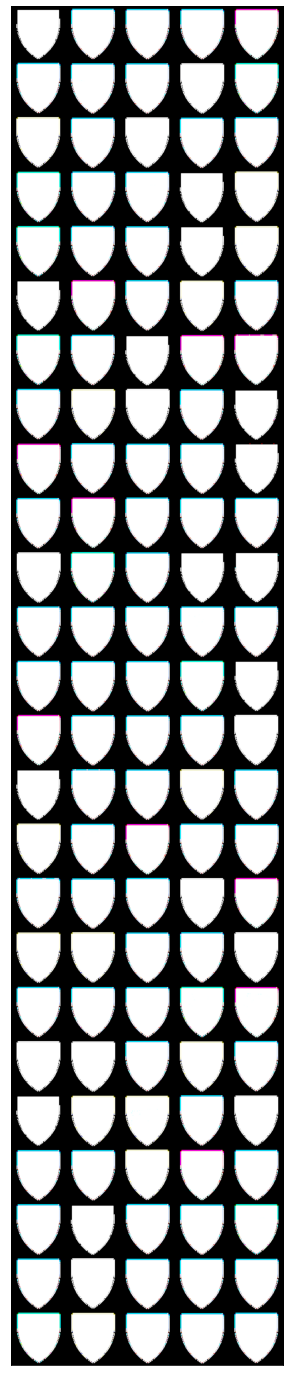

In [36]:


visualize_one_batch(train_data_loader)

Caption: image_296.png lion head V
(100, 100, 4)


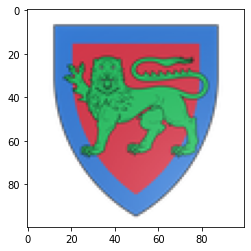

In [37]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


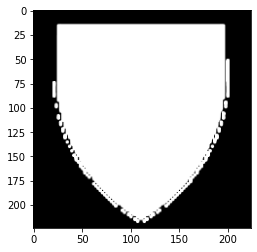

In [38]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


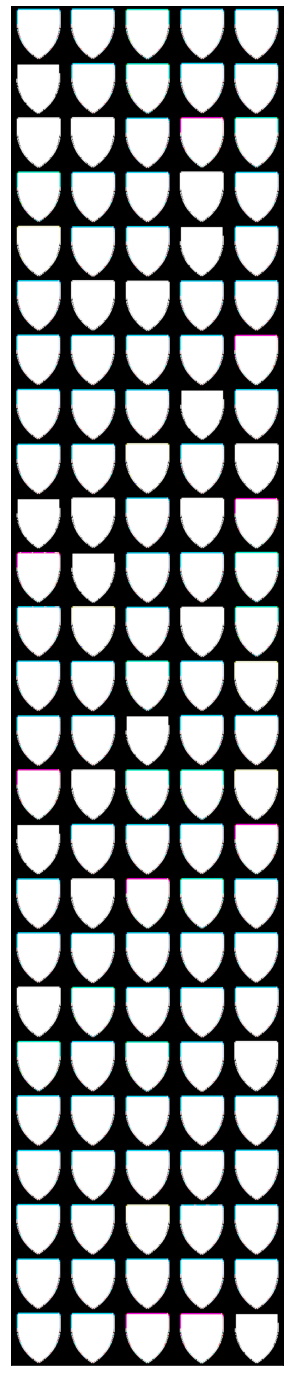

In [39]:
visualize_one_batch(val_data_loader)

# Model Definition

In [40]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


# Model Training, Validation and Testing

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 25
CUDA_LAUNCH_BLOCKING=1

### trying to clear the memory

In [ ]:
# https://www.kaggle.com/getting-started/140636
!pip install GPUtil


In [57]:

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [58]:
gc.collect()
torch.cuda.empty_cache()



In [59]:
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [60]:

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model, epochs, train_data_loader, val_data_loader, device)


Epoch 0:   0%|                                                         | 0/25 [00:02<?, ?batch/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 11.91 GiB total capacity; 10.56 GiB already allocated; 148.31 MiB free; 10.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Save model to disk

In [41]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-plural-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [42]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [92]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss()

# model_file_path =  data_location + '/classification-model-12-04-2022-14:34:36.pth'
model_file_path = f"{data_location}/classification-model-plural-12-11-2022-02:55:40.pth"

saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [93]:
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [94]:
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Test Loss = 0.5164
Test Accuracy = 78.3111111111111 % 



## Test pretrained model on real data - single


In [42]:
# real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


real_caption_file = real_data_location + 'test_real_captions_psumsq_single_cleaned.txt'
new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single_cleaned.txt'


In [ ]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)


In [43]:
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,-1_A G lion rampant.jpg,lion,rampant,G,1.884397e+06,1.445564e+06
1,-1_B G lion passt.jpg,lion,passt,G,8.101359e+04,5.683241e+04
2,-1_B O cross.jpg,cross,None,O,1.532679e+06,9.868818e+05
3,-1_G O cross moline.jpg,cross,moline,O,1.928653e+06,1.383184e+06
4,-1_G O lion rampant.jpg,lion,rampant,O,1.657027e+06,1.124069e+06
...,...,...,...,...,...,...
188,9189_A G cross.jpg,cross,None,G,7.879020e+05,6.028561e+05
189,9298_G O lion rampant.jpg,lion,rampant,O,7.961530e+05,5.912544e+05
190,9771_B O eagle.jpg,eagle,None,O,3.113132e+05,1.837900e+05
191,9929_A S eagle.jpg,eagle,None,S,6.978210e+05,5.172552e+05


In [51]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file)


In [44]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,-1_A G lion rampant.jpg,lion,rampant,G,1.884397e+06,1.445564e+06,20
1,-1_B G lion passt.jpg,lion,passt,G,8.101359e+04,5.683241e+04,8
2,-1_B O cross.jpg,cross,None,O,1.532679e+06,9.868818e+05,34
3,-1_G O cross moline.jpg,cross,moline,O,1.928653e+06,1.383184e+06,40
4,-1_G O lion rampant.jpg,lion,rampant,O,1.657027e+06,1.124069e+06,21
...,...,...,...,...,...,...,...
188,9189_A G cross.jpg,cross,None,G,7.879020e+05,6.028561e+05,33
189,9298_G O lion rampant.jpg,lion,rampant,O,7.961530e+05,5.912544e+05,21
190,9771_B O eagle.jpg,eagle,None,O,3.113132e+05,1.837900e+05,52
191,9929_A S eagle.jpg,eagle,None,S,6.978210e+05,5.172552e+05,53


In [45]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [54]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [46]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


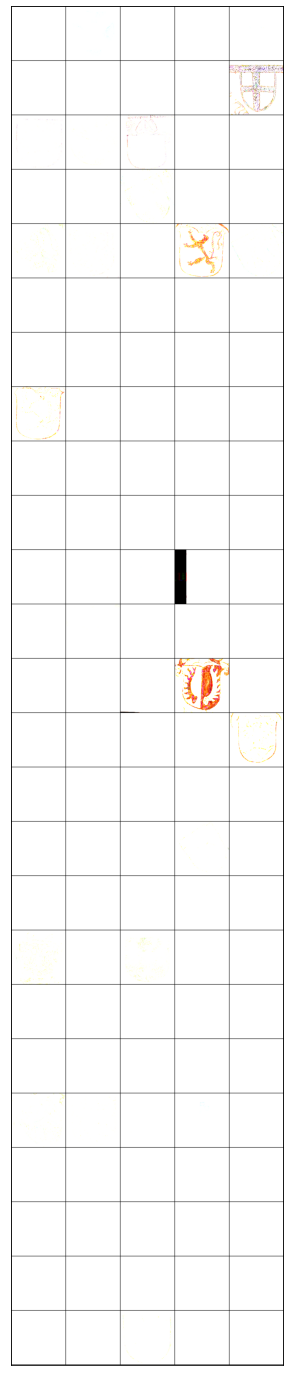

In [47]:

visualize_one_batch(real_test_data_loader)


In [48]:
test_classification_model(model, real_test_data_loader)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
Test Loss = 8.4949
Test Accuracy = 0.0 % 



## Test pretrained model on real data - single & plural


In [95]:
# real_data_location =  '/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out/'
real_data_location =  '/home/salnabulsi/coat-of-arms/data/cropped_coas/out/'
real_caption_file = real_data_location + 'test_real_captions_psumsq.txt'
# new_real_caption_file = real_data_location + '/test_real_labels_psumsq.txt'
# new_real_with_class_caption_file = real_data_location + 'new-test-real-labels-with-class-psumsq.txt'


real_caption_file = real_data_location + 'test_real_captions_psumsq_single-and-plural_cleaned.txt'
new_real_caption_file = real_data_location + '/test_real_labels_psumsq_single-and-plural_cleaned.txt'
new_real_with_class_caption_file = real_data_location + 'real_labels_with_class_psumsq_single-and-plural_cleaned.txt'


In [96]:
creat_caption_file(new_real_caption_file, 'image,charge,mod,color,psum,psum_sq')
write_break_down_columns(real_caption_file, new_real_caption_file)


In [97]:
df = pd.read_csv(new_real_caption_file).fillna(MISSING_TOKEN)
df            

,image,charge,mod,color,psum,psum_sq
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05


In [98]:
creat_caption_file(new_real_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')
write_class_colum(df, new_real_with_class_caption_file,CLASSES_MAP_PLURAL)


In [99]:
df_new = pd.read_csv(new_real_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,1426_G O 3 lions.jpg,lions,None,O,7.053774e+05,5.096137e+05,2
1,27623_G A 3 lions.jpg,lions,None,A,7.676897e+05,5.349798e+05,4
2,3298_O S 3 lions.jpg,lions,None,S,7.240464e+05,4.412956e+05,17
3,-1_B O 3 lions.jpg,lions,None,O,2.095022e+05,1.465410e+05,2
4,-1_S O 2 lions passt guard.jpg,lions,passt guard,O,1.387995e+06,8.966109e+05,28
5,22367_O B 3 lions.jpg,lions,None,B,7.777766e+05,5.546259e+05,3
6,18885_O S 3 lions passt guard.jpg,lions,passt guard,S,2.817084e+06,1.838050e+06,27
7,779_O S 3 lions.jpg,lions,None,S,7.574717e+05,5.712754e+05,17
8,22708_B A 2 lions passt guard.jpg,lions,passt guard,A,8.165868e+05,6.293604e+05,31
9,2_A S 3 lions.jpg,lions,None,S,8.508724e+05,6.689348e+05,17


In [100]:
# it's clear from the output above that plural gets None as a class. We didn't train our baseline model on any plural

In [101]:
real_images_location = real_data_location + '/resized'

# essentila for calc mean
real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)

In [64]:
# r_mean = get_mean(real_test_dataset, real_test_data_loader, 500 , 500)
# r_std = get_std(real_test_dataset, real_test_data_loader, r_mean, 500 , 500)

# r_mean,r_std 


In [102]:


real_test_dataset = CoAClassDataset(real_images_location, 
                     new_real_with_class_caption_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

real_test_random_sampler = RandomSampler(real_test_dataset)

real_test_data_loader = DataLoader(
    dataset = real_test_dataset,
    batch_size = BATCH_SIZE,
    sampler = real_test_random_sampler,
    num_workers = NUM_WORKER,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


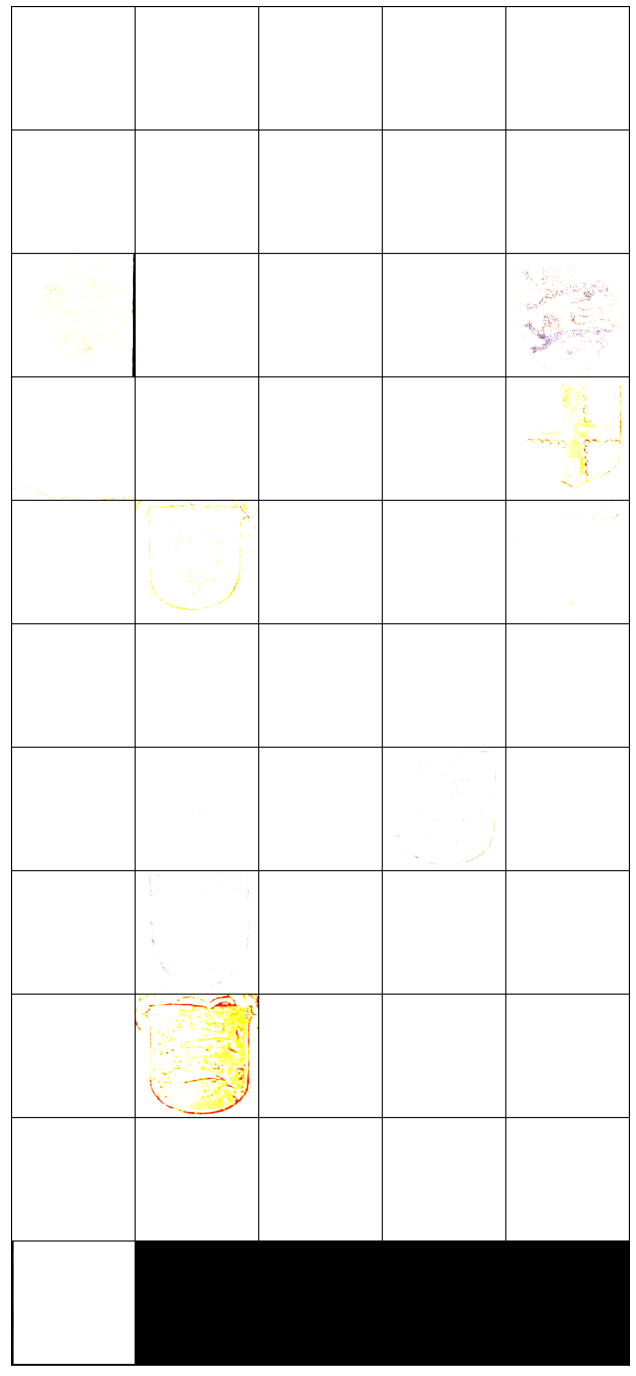

In [103]:

visualize_one_batch(real_test_data_loader)


In [104]:
test_classification_model(model, real_test_data_loader)


<class 'torch.Tensor'>
Test Loss = 6.4181
Test Accuracy = 5.8824 % 

